# Dataset

1. **inputs_weather_train.npy**: For each record, daily weather data - a total of 214 days spanning the crop growing season (defined April 1 through October 31). Daily weather records were compiled based on the nearest grid point from a gridded 30km product. Each day is represented by the following 7 weather variables - 
- Average Direct Normal Irradiance (ADNI)
- Average Precipitation (AP)
- Average Relative Humidity (ARH)
- Maximum Direct Normal Irradiance (MDNI)
- Maximum Surface Temperature (MaxSur)
- Minimum Surface Temperature (MinSur)
- Average Surface Temperature (AvgSur)

2. **inputs_others_train.npy**: Maturity Group (MG), Genotype ID, State, Year, and Location for each performance record.

3. **yield_train.npy**: Yearly crop yield value for each record.

We provide genotype clustering information in clusterID_genotype.npy. The file contains cluster ID for each of the 5839 genotypes. Participants may or may not use this information. We developed a completely connected pedigree for all lines with available parentage information, resulting in the formation of a 5839 x 5839 correlation matrix. 

**Feel free to use external datasets for the competition**. For the reproducibility of the results and prize money distribution, the top three teams must provide the open-source code and any external datasets used for the competition.

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from numpy.random import seed
from sklearn.preprocessing import StandardScaler

import graphviz
from datetime import date
import time
import pyreadr


import os
import torch
import torch.nn as nn
import torch.optim as optimizers
from torch.autograd import Variable
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score
from torchviz import make_dot

import math

print(torch.__version__) # 1.9.1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

1.9.1+cu111
cuda


# Load data

In [4]:
Y = np.load('./Dataset_Competition/Training/yield_train.npy')
Weather_train = np.load('./Dataset_Competition/Training/inputs_weather_train.npy')
ClusterID = np.load('./Dataset_Competition/clusterID_genotype.npy')

# Extract MG
df_train = np.load('./Dataset_Competition/Training/inputs_others_train.npy')
df_train = pd.DataFrame(df_train, columns=('MG', 'Genotype', 'State', 'Year', 'Site'))
MG = df_train['MG'].astype('category')
MG = MG.to_numpy()
# MG = StandardScaler().fit(MG[:,:,6])
# MG = scaler_x0.transform(MG[:,:,6])
MG = MG.reshape(-1,1)

# Transform Genotype into ClusterID, and stack with MG
# Genotype = df_train['Genotype'].astype('category')
# Genotype = Genotype.to_numpy()
# K = np.empty(len(Genotype))
# for i in range(len(ClusterID)):
#     K[Genotype==i] = ClusterID[i]
# K = K.reshape(-1,1)
# MG = np.hstack([MG, K])

# Standardization prcess
scaler_x0 = StandardScaler().fit(Weather_train[:,:,0])
scaled_x0 = scaler_x0.transform(Weather_train[:,:,0])
scaler_x1 = StandardScaler().fit(Weather_train[:,:,1])
scaled_x1 = scaler_x1.transform(Weather_train[:,:,1])
scaler_x2 = StandardScaler().fit(Weather_train[:,:,2])
scaled_x2 = scaler_x2.transform(Weather_train[:,:,2])
scaler_x3 = StandardScaler().fit(Weather_train[:,:,3])
scaled_x3 = scaler_x3.transform(Weather_train[:,:,3])
scaler_x4 = StandardScaler().fit(Weather_train[:,:,4])
scaled_x4 = scaler_x4.transform(Weather_train[:,:,4])
scaler_x5 = StandardScaler().fit(Weather_train[:,:,5])
scaled_x5 = scaler_x5.transform(Weather_train[:,:,5])
scaler_x6 = StandardScaler().fit(Weather_train[:,:,6])
scaled_x6 = scaler_x6.transform(Weather_train[:,:,6])
X = np.dstack([scaled_x0, scaled_x1, scaled_x2, scaled_x3, scaled_x4, scaled_x5, scaled_x6])

# Trancation
# X = X[:,np.arange(0,214,7),:] 

#####################################
# Load training and validation data #
#####################################
# 10% is test, 10% is val, 80% is training
seed(888)
X_train, X_val = train_test_split(X, test_size=0.8, shuffle=True, random_state=888)
X_val, X_test = train_test_split(X_val, test_size=0.5, shuffle=True, random_state=888)

Y_train, Y_val = train_test_split(Y, test_size=0.8, shuffle=True, random_state=888)
Y_val, Y_test = train_test_split(Y_val, test_size=0.5, shuffle=True, random_state=888)

MG_train, MG_val = train_test_split(MG, test_size=0.8, shuffle=True, random_state=888)
MG_val, MG_test = train_test_split(MG_val, test_size=0.5, shuffle=True, random_state=888)

##################
# Load test data #
##################
'''
Remind that values should be standardized
'''

# Transform into tensor
X_train = X_train.astype('float')
X_val = X_val.astype('float')
X_test = X_test.astype('float')

X_train = torch.from_numpy(X_train).float()
Y_train = torch.from_numpy(Y_train).float()
X_val = torch.from_numpy(X_val).float()
Y_val = torch.from_numpy(Y_val).float()
X_test = torch.from_numpy(X_test).float()
Y_test = torch.from_numpy(Y_test).float()

Y_train = Y_train.view(-1,1)
Y_val = Y_val.view(-1,1)
Y_test = Y_test.view(-1,1)


MG_train = MG_train.astype('float')
MG_val = MG_val.astype('float')
MG_test = MG_test.astype('float')

MG_train = torch.from_numpy(MG_train).int()
MG_val = torch.from_numpy(MG_val).int()
MG_test = torch.from_numpy(MG_test).int()

In [5]:
X.shape

(93028, 214, 7)

In [7]:
# Check the sample size for each state
# df = pd.DataFrame(df_train, columns=('MG', 'Genotype', 'State', 'Year', 'Site'))
# tab = df.groupby(['State']).size()
# tab

# CNN
X (weather data) is treated as indepedent inputs

# Define functions

In [6]:
# Prediction function
def batch_pred(X,MG):
    global x
    pred_list = []
    batch_size = 512
    x = 0
    for i in range(math.ceil(X.shape[0]/batch_size)):
        with torch.no_grad():
            temp_X = X[x:x+batch_size].to(device)
            temp_MG = MG[x:x+batch_size].to(device)
            
            # For independent multiple inputs
            x0 = temp_X[:,:,0].unsqueeze(1)
            x1 = temp_X[:,:,1].unsqueeze(1)
            x2 = temp_X[:,:,2].unsqueeze(1)
            x3 = temp_X[:,:,3].unsqueeze(1)
            x4 = temp_X[:,:,4].unsqueeze(1)
            x5 = temp_X[:,:,5].unsqueeze(1)
            x6 = temp_X[:,:,6].unsqueeze(1)

            pred = model(x0,x1,x2,x3,x4,x5,x6,temp_MG).detach().cpu().numpy().astype('float').tolist()
        pred_list.extend(pred)
        x = x + batch_size
    return pred_list

# Model Architecture (CNN-LF)

In [7]:
'''Model Architecture'''

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class CNN_LF(nn.Module):
    def __init__(self):
        super(CNN_LF, self).__init__()
        self.features0 = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=4, kernel_size=30, stride=1, padding=0),
            nn.MaxPool1d(2),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=3, stride=1, padding=0),
            nn.MaxPool1d(2),
            nn.ReLU(),
        )
        
        self.fc1 = nn.Sequential(
#             nn.Linear(8*3*3,16),
            nn.Linear(180,16),
            nn.ReLU(),
        )
        self.fc2 = nn.Linear(16,1)
        self.fc3 = nn.Sequential(
            nn.Linear(8,128),# weather 7, MG, CusterID
            nn.ReLU(),
        )
        self.regressor = nn.Linear(128, 1)
        
    def forward(self, x0, x1, x2, x3, x4, x5, x6, MG):
        x0 = self.features0(x0)
        x1 = self.features0(x1)
        x2 = self.features0(x2)
        x3 = self.features0(x3)
        x4 = self.features0(x4)
        x5 = self.features0(x5)
        x6 = self.features0(x6)
        
        x0 = x0.view(x0.size(0), -1)
        x1 = x1.view(x1.size(0), -1)
        x2 = x2.view(x2.size(0), -1)
        x3 = x3.view(x3.size(0), -1)
        x4 = x4.view(x4.size(0), -1)
        x5 = x5.view(x5.size(0), -1)
        x6 = x6.view(x6.size(0), -1)
        
        x0 = self.fc1(x0)
        x1 = self.fc1(x1)
        x2 = self.fc1(x2)
        x3 = self.fc1(x3)
        x4 = self.fc1(x4)
        x5 = self.fc1(x5)
        x6 = self.fc1(x6)
        
        x0 = self.fc2(x0)
        x1 = self.fc2(x1)
        x2 = self.fc2(x2)
        x3 = self.fc2(x3)
        x4 = self.fc2(x4)
        x5 = self.fc2(x5)
        x6 = self.fc2(x6)
        
        x = torch.cat((x0,x1,x2,x3,x4,x5,x6,MG), dim=1)
        x = self.fc3(x)
        x = self.regressor(x)
        return x

In [8]:
# For checking demension
batch_size = 10
x0 = torch.randn(batch_size, 1, 214)
x1 = torch.randn(batch_size, 1, 214)
x2 = torch.randn(batch_size, 1, 214)
x3 = torch.randn(batch_size, 1, 214)
x4 = torch.randn(batch_size, 1, 214)
x5 = torch.randn(batch_size, 1, 214)
x6 = torch.randn(batch_size, 1, 214)
MG = torch.randn(batch_size, 1) # MG / ClusterID

features0 = nn.Sequential(
    nn.Conv1d(in_channels=1, out_channels=4, kernel_size=30, stride=1, padding=0),
    nn.MaxPool1d(2),
    nn.Conv1d(in_channels=4, out_channels=4, kernel_size=3, stride=1, padding=0),
    nn.MaxPool1d(2),
    nn.ReLU(),
    )
        
fc1 = nn.Sequential(
    nn.Linear(180,16),
    nn.ReLU(),
    )
fc2 = nn.Linear(16,1)
fc3 = nn.Sequential(
    nn.Linear(8,128),
    nn.ReLU(),
    )
regressor = nn.Linear(128, 1)

print(x0.shape)

x0 = features0(x0)
x1 = features0(x1)
x2 = features0(x2)
x3 = features0(x3)
x4 = features0(x4)
x5 = features0(x5)
x6 = features0(x6)

print(x0.shape)

x0 = x0.view(x0.size(0), -1)
x1 = x1.view(x1.size(0), -1)
x2 = x2.view(x2.size(0), -1)
x3 = x3.view(x3.size(0), -1)
x4 = x4.view(x4.size(0), -1)
x5 = x5.view(x5.size(0), -1)
x6 = x6.view(x6.size(0), -1)

print(x0.shape)

x0 = fc1(x0)
x1 = fc1(x1)
x2 = fc1(x2)
x3 = fc1(x3)
x4 = fc1(x4)
x5 = fc1(x5)
x6 = fc1(x6)

print(x0.shape)

x0 = fc2(x0)
x1 = fc2(x1)
x2 = fc2(x2)
x3 = fc2(x3)
x4 = fc2(x4)
x5 = fc2(x5)
x6 = fc2(x6)

print(x0.shape)

x = torch.cat((x0,x1,x2,x3,x4,x5,x6,MG), dim=1)

print(x.shape)

torch.Size([10, 1, 214])
torch.Size([10, 4, 45])
torch.Size([10, 180])
torch.Size([10, 16])
torch.Size([10, 1])
torch.Size([10, 8])


In [9]:
# Visualize model architecture
batch_size = 1
x0 = torch.randn(batch_size, 1, 214)
x1 = torch.randn(batch_size, 1, 214)
x2 = torch.randn(batch_size, 1, 214)
x3 = torch.randn(batch_size, 1, 214)
x4 = torch.randn(batch_size, 1, 214)
x5 = torch.randn(batch_size, 1, 214)
x6 = torch.randn(batch_size, 1, 214)
MG = torch.randn(batch_size, 1) # MG and ClusterID

model = CNN_LF()

# summary(model,(channels,H,W))
# summary(model,input_size=[x0.shape[1:4],x1.shape[1:4],x2.shape[1:4],x3.shape[1:4]])
print(model)

# Visualize the architecture using make_dot
model2 = CNN_LF()
yDummy = model2(x0, x1, x2, x3, x4, x5, x6, MG)
make_dot(yDummy, params=dict(model.named_parameters()))

# Visualize the architecture using Netron
dummy_input = x0,x1,x2,x3,x4,x5,x6,MG
model.to('cpu')
torch.onnx.export(model, dummy_input,'./cnn_lf.onnx', input_names=['x0','x1','x2','x3','x4','x5','x6','MG'], output_names='y')

CNN_LF(
  (features0): Sequential(
    (0): Conv1d(1, 4, kernel_size=(30,), stride=(1,))
    (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv1d(4, 4, kernel_size=(3,), stride=(1,))
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): ReLU()
  )
  (fc1): Sequential(
    (0): Linear(in_features=180, out_features=16, bias=True)
    (1): ReLU()
  )
  (fc2): Linear(in_features=16, out_features=1, bias=True)
  (fc3): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): ReLU()
  )
  (regressor): Linear(in_features=128, out_features=1, bias=True)
)


In [10]:
#################
# Train process #
#################

model = CNN_LF()
model.to(device)

counter = 0 # For earlystop

PATIENCE = 10
EPOCH = 1000 # 500
BATCH_SIZE = 512

losses = []
torch.manual_seed(123)    # reproducible

loss_func = nn.MSELoss()
optimizer = optimizers.Adam(model.parameters(), lr=0.001)#default is 0.001

# Dataloader
train_len = X_train.size()[0]
val_len = X_val.size()[0]
test_len = X_test.size()[0]

X = X_train
Y = Y_train
MG = MG_train
trainset = torch.utils.data.TensorDataset(X, MG, Y)
X = X_val
Y = Y_val
MG = MG_val
valset = torch.utils.data.TensorDataset(X, MG, Y)
X = X_test
Y = Y_test
MG = MG_test
testset = torch.utils.data.TensorDataset(X, MG, Y)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True)
data_loaders = {"train": train_loader, "val": validation_loader, "test":test_loader}
data_lengths = {"train": train_len, "val": val_len, "test": test_len}

losses_train = []
losses_val = []
losses_test = []

for epoch in range(EPOCH):
    print('Epoch {}/{}'.format(epoch + 1, EPOCH))

    # Each epoch has a training and validation phase
    for phase in ['train', 'val', 'test']:
        if phase == 'train':
            #optimizer = scheduler(optimizer, epoch)
            model.train(True)  # Set model to training mode
        else:
            model.train(False)  # Set model to evaluate mode

        running_loss = 0.0

        # Iterate over data.
        for data in data_loaders[phase]:

            # get the input images and their corresponding labels
            X, MG, Y = data

            # flatten pts
            #key_pts = key_pts.view(key_pts.size(0), -1)

            # wrap them in a torch Variable
            X, MG, Y = Variable(X), Variable(MG), Variable(Y)

            # convert variables to floats for regression loss
            Y = Y.type(torch.cuda.FloatTensor)
            X = X.type(torch.cuda.FloatTensor)
            MG = MG.type(torch.cuda.FloatTensor)

            # For independent inputs
            x0 = X[:,:,0].unsqueeze(1)
            x1 = X[:,:,1].unsqueeze(1)
            x2 = X[:,:,2].unsqueeze(1)
            x3 = X[:,:,3].unsqueeze(1)
            x4 = X[:,:,4].unsqueeze(1)
            x5 = X[:,:,5].unsqueeze(1)
            x6 = X[:,:,6].unsqueeze(1)

            # forward pass to get outputs
            outputs = model(x0,x1,x2,x3,x4,x5,x6,MG)

            # calculate the loss between predicted and target keypoints
            loss = loss_func(outputs, Y)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # backward + optimize only if in training phase
            if phase == 'train':
                loss.backward()
                # update the weights
                optimizer.step()

            # print loss statistics
            running_loss += loss.data.item() #[0]

        epoch_loss = running_loss / data_lengths[phase]

        if phase == 'train':
            losses_train.append(epoch_loss)
        elif phase =='val':
            losses_val.append(epoch_loss)
            # Earlystopping
            if epoch == 0:
                best_score = epoch_loss
            else:
                best_score = min(losses_val)
                if losses_val[-1] > best_score:
                    counter += 1
                elif losses_val[-1] == best_score:
                    counter = 0
                    filepath = './model/CNN_LF_BestModel.pth'
                    torch.save(model.state_dict(), filepath) # save the best-score model
        else:
            losses_test.append(epoch_loss)
                    
        if phase == 'train':
            print('{} Loss: {:.4f}'.format(phase, epoch_loss))
        elif phase == 'val':
            print('{} Loss: {:.4f}'.format(phase, epoch_loss))
            print('Counter: {}'.format(counter))
            print('-' * 10)

    # Earlystopping
    if counter == PATIENCE:
        print("Early Stopping!")
        print('---Training completed at the {}th epoch'.format(epoch+1))
        break

Epoch 1/1000
train Loss: 5.2425
val Loss: 4.0120
Counter: 0
----------
Epoch 2/1000
train Loss: 1.6601
val Loss: 0.5940
Counter: 0
----------
Epoch 3/1000
train Loss: 0.5716
val Loss: 0.5319
Counter: 0
----------
Epoch 4/1000
train Loss: 0.5279
val Loss: 0.5135
Counter: 0
----------
Epoch 5/1000
train Loss: 0.5169
val Loss: 0.5048
Counter: 0
----------
Epoch 6/1000
train Loss: 0.5088
val Loss: 0.5001
Counter: 0
----------
Epoch 7/1000
train Loss: 0.5029
val Loss: 0.4964
Counter: 0
----------
Epoch 8/1000
train Loss: 0.5005
val Loss: 0.4917
Counter: 0
----------
Epoch 9/1000
train Loss: 0.4953
val Loss: 0.4873
Counter: 0
----------
Epoch 10/1000
train Loss: 0.4930
val Loss: 0.4845
Counter: 0
----------
Epoch 11/1000
train Loss: 0.4874
val Loss: 0.4824
Counter: 0
----------
Epoch 12/1000
train Loss: 0.4834
val Loss: 0.4773
Counter: 0
----------
Epoch 13/1000
train Loss: 0.4801
val Loss: 0.4746
Counter: 0
----------
Epoch 14/1000
train Loss: 0.4778
val Loss: 0.4701
Counter: 0
----------
E

Epoch 115/1000
train Loss: 0.2185
val Loss: 0.2250
Counter: 0
----------
Epoch 116/1000
train Loss: 0.2183
val Loss: 0.2241
Counter: 0
----------
Epoch 117/1000
train Loss: 0.2177
val Loss: 0.2239
Counter: 0
----------
Epoch 118/1000
train Loss: 0.2175
val Loss: 0.2230
Counter: 0
----------
Epoch 119/1000
train Loss: 0.2178
val Loss: 0.2231
Counter: 1
----------
Epoch 120/1000
train Loss: 0.2164
val Loss: 0.2219
Counter: 0
----------
Epoch 121/1000
train Loss: 0.2159
val Loss: 0.2226
Counter: 1
----------
Epoch 122/1000
train Loss: 0.2164
val Loss: 0.2204
Counter: 0
----------
Epoch 123/1000
train Loss: 0.2134
val Loss: 0.2196
Counter: 0
----------
Epoch 124/1000
train Loss: 0.2153
val Loss: 0.2250
Counter: 1
----------
Epoch 125/1000
train Loss: 0.2154
val Loss: 0.2228
Counter: 2
----------
Epoch 126/1000
train Loss: 0.2144
val Loss: 0.2182
Counter: 0
----------
Epoch 127/1000
train Loss: 0.2112
val Loss: 0.2174
Counter: 0
----------
Epoch 128/1000
train Loss: 0.2124
val Loss: 0.2173


val Loss: 0.1837
Counter: 3
----------
Epoch 228/1000
train Loss: 0.1725
val Loss: 0.1817
Counter: 0
----------
Epoch 229/1000
train Loss: 0.1723
val Loss: 0.1860
Counter: 1
----------
Epoch 230/1000
train Loss: 0.1742
val Loss: 0.1808
Counter: 0
----------
Epoch 231/1000
train Loss: 0.1735
val Loss: 0.1827
Counter: 1
----------
Epoch 232/1000
train Loss: 0.1715
val Loss: 0.1810
Counter: 2
----------
Epoch 233/1000
train Loss: 0.1721
val Loss: 0.1801
Counter: 0
----------
Epoch 234/1000
train Loss: 0.1707
val Loss: 0.1800
Counter: 0
----------
Epoch 235/1000
train Loss: 0.1717
val Loss: 0.1805
Counter: 1
----------
Epoch 236/1000
train Loss: 0.1707
val Loss: 0.1805
Counter: 2
----------
Epoch 237/1000
train Loss: 0.1702
val Loss: 0.1854
Counter: 3
----------
Epoch 238/1000
train Loss: 0.1713
val Loss: 0.1804
Counter: 4
----------
Epoch 239/1000
train Loss: 0.1713
val Loss: 0.1815
Counter: 5
----------
Epoch 240/1000
train Loss: 0.1701
val Loss: 0.1799
Counter: 0
----------
Epoch 241/10

Epoch 340/1000
train Loss: 0.1536
val Loss: 0.1632
Counter: 4
----------
Epoch 341/1000
train Loss: 0.1532
val Loss: 0.1641
Counter: 5
----------
Epoch 342/1000
train Loss: 0.1529
val Loss: 0.1685
Counter: 6
----------
Epoch 343/1000
train Loss: 0.1530
val Loss: 0.1622
Counter: 0
----------
Epoch 344/1000
train Loss: 0.1524
val Loss: 0.1641
Counter: 1
----------
Epoch 345/1000
train Loss: 0.1532
val Loss: 0.1664
Counter: 2
----------
Epoch 346/1000
train Loss: 0.1528
val Loss: 0.1633
Counter: 3
----------
Epoch 347/1000
train Loss: 0.1519
val Loss: 0.1616
Counter: 0
----------
Epoch 348/1000
train Loss: 0.1516
val Loss: 0.1621
Counter: 1
----------
Epoch 349/1000
train Loss: 0.1515
val Loss: 0.1616
Counter: 0
----------
Epoch 350/1000
train Loss: 0.1515
val Loss: 0.1614
Counter: 0
----------
Epoch 351/1000
train Loss: 0.1508
val Loss: 0.1614
Counter: 0
----------
Epoch 352/1000
train Loss: 0.1510
val Loss: 0.1653
Counter: 1
----------
Epoch 353/1000
train Loss: 0.1552
val Loss: 0.1759


# Check the best model

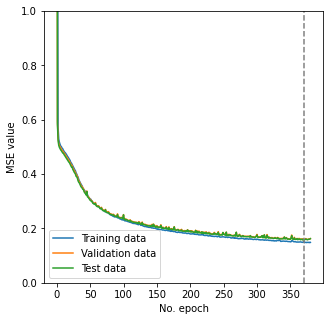

Train


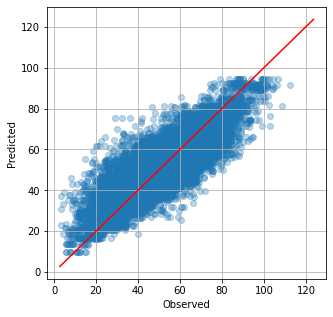

Validation


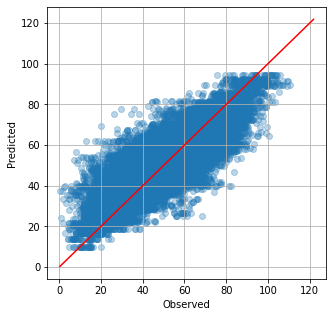

Test


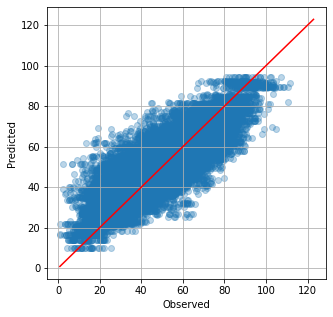

Train RMSE: 8.59
Train MAE: 6.59
Train R2: 0.712
Validation RMSE: 9.01
Validation MAE: 6.87
Validation R2: 0.683
Test RMSE: 8.98
Test MAE: 6.87
Test R2: 0.681


In [11]:
# Loss function
plt.figure(figsize=(5,5))
plt.plot(losses_train,label='Training data') 
plt.plot(losses_val,label='Validation data') 
plt.plot(losses_test,label='Test data') 

plt.axvline(x=epoch+1-PATIENCE, ls='--', color='grey')
plt.ylabel('MSE value')
plt.xlabel('No. epoch')
plt.legend()
plt.ylim([0,1])
plt.show()

# Prediction
# Resnet is required to be put in evaluation mode in order 
# to do prediction / evaluation
model = CNN_LF()
model.to(device)
filepath = './model/CNN_LF_BestModel.pth'
model.load_state_dict(torch.load(filepath))
model.eval()

import math

pred_train = batch_pred(X_train,MG_train)
pred_val = batch_pred(X_val,MG_val)
pred_test = batch_pred(X_test,MG_test)
            
# Plotting model results
print("Train")
plt.figure(figsize=(5,5))
plt.scatter(Y_train.cpu().numpy(), pred_train, alpha=0.3) 
plt.xlabel('Observed') 
plt.ylabel('Predicted')
x = np.arange(0.9*min(Y_train).item(), 1.1*max(Y_train).item(), 0.1)
y = x
plt.plot(x, y,"r-")   
plt.grid()
plt.show()

print("Validation")
plt.figure(figsize=(5,5))
plt.scatter(Y_val.cpu().numpy(), pred_val, alpha=0.3) 
plt.xlabel('Observed') 
plt.ylabel('Predicted')
x = np.arange(0.9*min(Y_val).item(), 1.1*max(Y_val).item(), 0.1)
y = x
plt.plot(x, y,"r-")   
plt.grid()
plt.show()

print("Test")
plt.figure(figsize=(5,5))
plt.scatter(Y_test.cpu().numpy(), pred_test, alpha=0.3) 
plt.xlabel('Observed') 
plt.ylabel('Predicted')
x = np.arange(0.9*min(Y_test).item(), 1.1*max(Y_test).item(), 0.1)
y = x
plt.plot(x, y,"r-")   
plt.grid()
plt.show()

print("Train RMSE: %.2f" % (np.sqrt(mean_squared_error(Y_train.cpu().numpy(), pred_train))))
print("Train MAE: %.2f" % (mean_absolute_error(Y_train.cpu().numpy(), pred_train)))
print("Train R2: %.3f" % (r2_score(Y_train.cpu().numpy(), pred_train)))

print("Validation RMSE: %.2f" % (np.sqrt(mean_squared_error(Y_val.cpu().numpy(), pred_val))))
print("Validation MAE: %.2f" % (mean_absolute_error(Y_val.cpu().numpy(), pred_val)))
print("Validation R2: %.3f" % (r2_score(Y_val.cpu().numpy(), pred_val)))

print("Test RMSE: %.2f" % (np.sqrt(mean_squared_error(Y_test.cpu().numpy(), pred_test))))
print("Test MAE: %.2f" % (mean_absolute_error(Y_test.cpu().numpy(), pred_test)))
print("Test R2: %.3f" % (r2_score(Y_test.cpu().numpy(), pred_test)))

# 1. Model perfomance from the original paper
## Including All & Temporal Attention
- RMSE = 7.226
- MAE = 5.441
- Rsq = 0.795

## Including All & SVR-RBF
- RMSE = 7.875
- MAE = 5.976
- Rsq = 0.758

# 2. MLYakuza scores

Note that we don't have actual test dataset. So it's impossible to compare the score values with the original paper.

## LF-CNN without ClusterID 1st trial (Sep 24, 2021)
- RMSE = 8.26
- MAE = 6.31
- Rsq = 0.730

## LF-CNN without ClusterID 2nd trial (Sep 30, 2021)
Multiple 1D CNN layers are used.
- RMSE: 8.67
- MAE: 6.65
- R2: 0.702

## Random Forest without ClusterID 1st trial (Sep 27, 2021)
- RMSE = 7.51
- MAE = 5.67
- Rsq = 0.777

## Random Forest with ClusterID (Sep 28, 2021)
- RMSE = 8.02
- MAE = 6.01
- Rsq = 0.745

### Result: RF does not need ClusterID information

## Lasso without ClusterID (Sep 29, 2021)
- RMSE: 8.29
- MAE: 6.24
- R2: 0.728


## Lasso with ClusterID (Sep 29, 2021)
- RMSE: 8.29
- MAE: 6.24
- R2: 0.728